In [12]:
import pandas as pd
import tensorflow as tf
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
#import sklearn
import matplotlib.pyplot as plt
import copy
from torchvision import transforms
from keras.models import Sequential, save
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, MaxPool2D, Dropout, Softmax, ReLU
IMG_SIZE = 224

In [13]:
#NB default value for dropout rate is 0.2
from tensorflow.keras.applications import EfficientNetB0 
model = EfficientNetB0(include_top=False,weights='imagenet')

In [14]:
dir = '/content/drive/Othercomputers/Mon MacBook Pro/Documents/labelled_folder'

batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = dir,
    labels='inferred',
    batch_size = batch_size,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle = True,
    validation_split = 0.3,
    subset = 'training',
    seed = 123,
    label_mode='categorical')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = dir,
    labels='inferred',
    batch_size = batch_size,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle = True,
    validation_split = 0.3,
    subset = 'validation',
    seed = 123,
    label_mode='categorical')

Found 15339 files belonging to 7 classes.
Using 10738 files for training.
Found 15339 files belonging to 7 classes.
Using 4601 files for validation.


In [15]:
#Proceed with Data augmentation 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


In [16]:
import os
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [7]:
# Set random seed and set device to GPU
#torch.manual_seed(1234)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
from tensorflow.keras.applications import EfficientNetB0

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=7)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 5 #before this was set to 40
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 7)                4058538   
                                                                 
Total params: 4,058,538
Trainable params: 4,016,515
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/5
336/336 - 719s - loss: 2.3083 - accuracy: 0.3540 - val_loss: 1.6859 - val_accuracy: 0.3971 - 719s/epoch - 2s/step
Epoch 2/5
336/336 - 61s - loss: 1.7804 - accuracy: 0.3796 - val_loss: 1.5997 - val_accuracy: 0.3999 - 61s/epoch - 181m

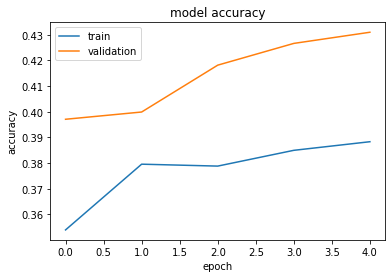

In [16]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)
#we can see in the plot that we have convergence between the training and validation accuracy (arround 75%)

In [17]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(7, activation="softmax", name="pred")(x) #take input the number of classes (here 7)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [18]:
with strategy.scope():
    model = build_model(num_classes=7)

epochs = 50
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
plot_hist(hist)

Epoch 1/50
336/336 - 28s - loss: 2.4165 - accuracy: 0.4074 - val_loss: 1.4403 - val_accuracy: 0.5088 - 28s/epoch - 82ms/step
Epoch 2/50
336/336 - 15s - loss: 1.6815 - accuracy: 0.4630 - val_loss: 1.4276 - val_accuracy: 0.4923 - 15s/epoch - 45ms/step
Epoch 3/50
336/336 - 15s - loss: 1.4508 - accuracy: 0.4792 - val_loss: 1.2779 - val_accuracy: 0.5438 - 15s/epoch - 44ms/step
Epoch 4/50
336/336 - 15s - loss: 1.3867 - accuracy: 0.4901 - val_loss: 1.2960 - val_accuracy: 0.5468 - 15s/epoch - 44ms/step
Epoch 5/50
336/336 - 15s - loss: 1.3637 - accuracy: 0.5000 - val_loss: 1.3124 - val_accuracy: 0.5377 - 15s/epoch - 44ms/step
Epoch 6/50
336/336 - 15s - loss: 1.3842 - accuracy: 0.4904 - val_loss: 1.3002 - val_accuracy: 0.5247 - 15s/epoch - 44ms/step
Epoch 7/50
336/336 - 15s - loss: 1.3750 - accuracy: 0.4930 - val_loss: 1.2860 - val_accuracy: 0.5221 - 15s/epoch - 45ms/step
Epoch 8/50
336/336 - 15s - loss: 1.3755 - accuracy: 0.4918 - val_loss: 1.2899 - val_accuracy: 0.5295 - 15s/epoch - 44ms/step


NameError: ignored

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
plot_hist(hist)

##VGG16

In [5]:
from keras.applications.vgg16 import VGG16
model = VGG16()
print(model.summary())

553476096/553467096 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [7]:
from keras.applications.vgg16 import VGG16

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = VGG16(include_top=True, weights=None, classes=7)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 40
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                             

In [27]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = VGG16(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(7, activation="softmax", name="pred")(x) #take input the number of classes (here 7)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="VGG16")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/25
336/336 - 30s - loss: 1.7309 - accuracy: 0.4394 - val_loss: 1.4163 - val_accuracy: 0.4819 - 30s/epoch - 88ms/step
Epoch 2/25
336/336 - 25s - loss: 1.4274 - accuracy: 0.4826 - val_loss: 1.4119 - val_accuracy: 0.4647 - 25s/epoch - 75ms/step
Epoch 3/25
336/336 - 25s - loss: 1.3651 - accuracy: 0.4945 - val_loss: 1.3708 - val_accuracy: 0.4829 - 25s/epoch - 75ms/step
Epoch 4/25
336/336 - 25s - loss: 1.3465 - accuracy: 0.4959 - val_loss: 1.4020 - val_accuracy: 0.4801 - 25s/epoch - 76ms/step
Epoch 5/25
336/336 - 25s - loss: 1.3466 - accuracy: 0.4990 - val_loss: 1.3008 - val_accuracy: 0.5281 - 25s/epoch - 75ms/step
Epoch 6/25
336/336 - 25s - loss: 1.3446 - accuracy: 0.5015 - val_loss: 1.3263 - val_accuracy: 0.5214 - 25s/epoch - 75ms/step
Epoch 7/25
336/336 - 25s - loss: 1.3411 - accuracy: 0.4978 - val_loss: 1.3248 - val_accuracy: 0.5097 - 25s/epoch - 75ms/step
Epoch 8/25
336/336 - 25s - loss: 1.3434 - accuracy: 0.5013 -

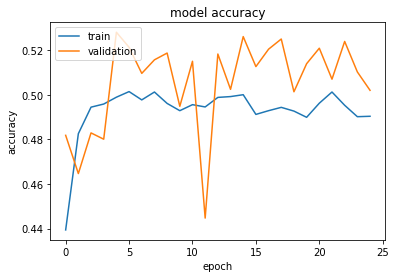

In [28]:
with strategy.scope():
    model = build_model(num_classes=7)

epochs = 25
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
plot_hist(hist)

Epoch 1/40
336/336 - 49s - loss: 0.4251 - accuracy: 0.8500 - val_loss: 0.8128 - val_accuracy: 0.7537 - 49s/epoch - 146ms/step
Epoch 2/40
336/336 - 44s - loss: 0.4018 - accuracy: 0.8591 - val_loss: 0.6501 - val_accuracy: 0.7844 - 44s/epoch - 132ms/step
Epoch 3/40
336/336 - 44s - loss: 0.3831 - accuracy: 0.8662 - val_loss: 0.7068 - val_accuracy: 0.7807 - 44s/epoch - 132ms/step
Epoch 4/40
336/336 - 44s - loss: 0.3691 - accuracy: 0.8715 - val_loss: 0.7291 - val_accuracy: 0.7757 - 44s/epoch - 132ms/step
Epoch 5/40
336/336 - 44s - loss: 0.3724 - accuracy: 0.8708 - val_loss: 0.7619 - val_accuracy: 0.7631 - 44s/epoch - 132ms/step
Epoch 6/40
336/336 - 44s - loss: 0.3479 - accuracy: 0.8797 - val_loss: 0.9382 - val_accuracy: 0.7257 - 44s/epoch - 132ms/step
Epoch 7/40
336/336 - 44s - loss: 0.3601 - accuracy: 0.8706 - val_loss: 0.8570 - val_accuracy: 0.7392 - 44s/epoch - 132ms/step
Epoch 8/40
336/336 - 44s - loss: 0.3448 - accuracy: 0.8797 - val_loss: 0.7142 - val_accuracy: 0.7927 - 44s/epoch - 132

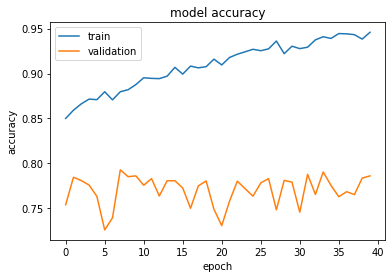

In [31]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 40
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
plot_hist(hist)